# Bethe-ansatz solution for one-dimensional XXZ model
## Hamiltonian
$$
H_{\text{xxz}} = -\sum_{j = 1}^{N} \frac{J}{2} [\sigma_j^x \sigma_{j+1}^x +\sigma_j^y \sigma_{j+1}^y +\Delta \sigma_j^z \sigma_{j+1}^z] - h \sum_{j = 1}^{N} \sigma_j^z
$$
$\Delta < -1$ is anti-ferromagmetism phase (gapped).   
$-1 < \Delta < 1$ is paramagnetism phase (gapless).    
$\Delta > 1$ is ferromagnetism phase (gapped).  

In [12]:
from __future__ import division, print_function
import os
import numpy as np
import scipy as sp 
from scipy import special
import math
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt 
from itertools import product
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.stats import gaussian_kde
import time
from numpy import linalg as LA
import random


class XXZ_1D():
    
    def __init__(self, N_spin, hfield, J, Delta):
        self.N_spin    = N_spin
        self.hfield    = hfield
        self.J         = J
        self.Delta     = Delta

    def XXZ_spectrum(self, M, I):
        # I_gs = [-(M_gs-1)/2 + i for i in range(M_gs)], quantum number set I_j for ground state.
        # M = number of downspin, for ground state M = N_spin/2
        self.M = M
        self.I = I
        def equations(k):
            lambda_ = [k[i] for i in range(self.M)]
            if abs(self.Delta) <= 1:
                eta = np.arccos(-1*self.Delta)
                eqM = [2*np.arctan(np.tanh(lambda_[j]/2)/np.tan(eta/2))
                - 2*np.pi*self.I[j]/self.N_spin 
                - (1/self.N_spin)*np.sum( 2*np.arctan( np.tanh((lambda_[j] - lambda_)/2)/np.tan(eta)) ) 
                for j in range(self.M)]
            elif self.Delta < -1:
                eta = np.arccosh(-1*self.Delta)
                def theta(n, lambda_,eta):
                    return 2*np.arctan(np.tan(lambda_/2)/np.tanh(n*eta/2))
                eqM = [theta(1, lambda_[j], eta)
                - 2*np.pi*self.I[j]/self.N_spin
                -(1/self.N_spin)*np.sum(theta(2,lambda_[j] - lambda_, eta))
                for j in range(self.M)]
            elif self.Delta > 1:
                eta = np.arccosh(abs(self.Delta))
                def theta(n, lambda_, eta):
                    return 2*np.arctan(np.tanh(n*eta/2)/np.tan(lambda_/2)) 
                eqM = [theta(1, lambda_[j], eta)
                - 2*np.pi*self.I[j]/self.N_spin
                -(1/self.N_spin)*np.sum(theta(2, (lambda_[j] - lambda_) , eta))
                for j in range(self.M)]
            return eqM

        lambda_ = least_squares(equations, np.zeros(self.M),
        bounds = (np.full(self.M, -np.pi), np.full(self.M, np.pi)),
        ftol=1e-05, xtol=1e-05, gtol=1e-05
        ).x
        
        if abs(self.Delta) <= 1:
            eta = np.arccos(-1*self.Delta)
            E = -2*np.sum(np.sin(eta)**2/(np.cosh(lambda_)-np.cos(eta))) -self.hfield*(self.N_spin*0.5 - self.M)
            p = (np.pi*self.M - (2*np.pi/self.N_spin)*np.sum(self.I)) % (2*np.pi)
        elif self.Delta < -1:
            eta = np.arccosh(-1*self.Delta)
            def theta(n, lambda_, eta):
                return 2*np.arctan(np.tan(lambda_/2)/np.tanh(n*eta/2)) 
            E = -2*np.sum(np.sinh(eta)**2/(np.cosh(eta)-np.cos(lambda_))) - self.hfield*(self.N_spin*0.5 - self.M)
            p = np.sum( np.pi - theta(1,lambda_, eta)) % (2*np.pi)
        elif self.Delta > 1:
            eta = np.arccosh(abs(self.Delta))
            def theta(n, lambda_, eta):
                return 2*np.arctan(np.tanh(n*eta/2)/np.tan(lambda_/2)) 
            E = -2*np.sum(np.sinh(eta)**2/(np.cosh(eta)-np.cos(lambda_))) - self.hfield*(self.N_spin*0.5 - self.M)
            p = np.sum( np.pi - theta(1,lambda_, eta)) % (2*np.pi)
        return E , p, lambda_

    def dispersion(self):
        XXZ_spectrum = self.XXZ_spectrum
        M_gs = int(self.N_spin/2)
        M = int(self.N_spin/2 - 1)
        I_gs = [-(M_gs-1)/2 + i for i in range(M_gs)]
        I_spinon_set = []
        for i in range(M+2):
            for j in range(M+1):          
                I_spinon = [-(self.N_spin - M - 1)/2 + i for i in range(M+2)]
                del I_spinon[i]
                del I_spinon[j]
                
                if I_spinon not in I_spinon_set:
                    I_spinon_set.append(I_spinon)
        Ep_array = []
        ct = 0
        for I_spinon_i in I_spinon_set:
            ct += 1
            J = 1
            E, p, lambda_ = XXZ_spectrum(M = M, I = I_spinon_i)
            Ep_array.append([E,p])
            ratio = (ct/len(I_spinon_set))*100
        E_gs = XXZ_spectrum(M = M_gs, I = I_gs)[0]
        y, x = np.array(Ep_array).T
        x = x/np.pi
        y -= E_gs
        Da = np.array([x, y])
        return Da
    
    def Gap(self):
        XXZ_spectrum = self.XXZ_spectrum
        M_gs = int(self.N_spin/2)
        M = int(self.N_spin/2 - 1)
        I_gs = [-(M_gs-1)/2 + i for i in range(M_gs)]
        I_Kpi = [-(self.N_spin - M - 1)/2 + 1 + i for i in range(M)]
        E_gs = XXZ_spectrum(M = M_gs, I = I_gs)[0]
        E_array = []
        E, p, lambda_ = XXZ_spectrum(M = M, I = I_Kpi)
        E_array.append(E)
        y = np.array(E_array).T
        y -= E_gs
        return y

## Ground state energy


XXZ model with N =  20 , hfield =  0 , Delta =  0.1 :
 Ground state energy = 
 -11.386484222880364 
 Momentum =
 0.0 
 Lambda = 
 [-2.69589444 -1.51663811 -0.93719928 -0.52079045 -0.16774477  0.16774477
  0.52079045  0.93719928  1.51663811  2.69589444]
Spinon excitation :


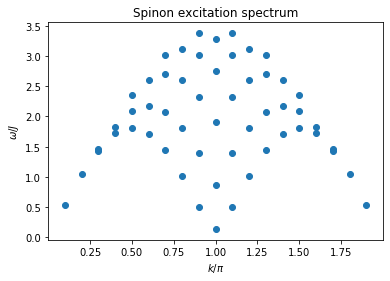

Gap (lowest excitation energy at $p = \pi$) = 
 [0.13787363]


In [34]:
N_s = 20
hf = 0 
Delta_ = 0.1
M_gs = int(N_s/2)
I_gs = [-(M_gs-1)/2 + i for i in range(M_gs)] # quantum number set I_j for ground state.
# M = number of downspin, for ground state M = N_spin/2

E_gs, p_gs, lambda_ = XXZ_1D(N_spin = N_s, hfield = hf ,J = 1, Delta = Delta_).XXZ_spectrum(M = M_gs, I = I_gs)
print("XXZ model with N = ",str(N_s),", hfield = ",str(hf),", Delta = ",str(Delta_),":\n",
"Ground state energy = \n",E_gs,
"\n Momentum =\n",p_gs,
"\n Lambda = \n", lambda_
)

print("Spinon excitation :")

spinon_excitation = XXZ_1D(N_spin = N_s,hfield= hf ,J = 1, Delta = Delta_).dispersion()
# spinon_excitation[0] for momentum coordinate of unit \pi
# spinon_excitation[1] for excitation energies
plt.scatter(
    spinon_excitation[0],
    spinon_excitation[1]
    )
plt.title("Spinon excitation spectrum")
plt.xlabel("$k/\pi$")
plt.ylabel("$\omega/J$")
plt.show()

gap_E = XXZ_1D(N_spin = N_s,hfield= hf ,J = 1, Delta = Delta_).Gap()
print("Gap (lowest excitation energy at $p = \pi$) = \n",gap_E)